In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
HUGGINGFACE_API_KEY = os.getenv("HUGGINGFACE_API_KEY")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")

os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"] = GROQ_API_KEY
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
os.environ["LANGSMITH_PROJECT"] = LANGSMITH_PROJECT
os.environ["HUGGINGFACE_API_KEY"] = HUGGINGFACE_API_KEY
os.environ["SERPER_API_KEY"] = SERPER_API_KEY

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(model_name = "llama-3.3-70b-versatile")

In [4]:
llm.invoke("I am a good boy")

AIMessage(content="That's great to hear. Being a good boy is something to be proud of. What makes you think you're a good boy, and what kind of good things have you been doing?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 40, 'total_tokens': 79, 'completion_time': 0.114661527, 'prompt_time': 0.010958667, 'queue_time': 0.209077091, 'total_time': 0.125620194}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--3912bb5f-f34f-4ef9-8143-f41189f87bae-0', usage_metadata={'input_tokens': 40, 'output_tokens': 39, 'total_tokens': 79})

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState, StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage

In [6]:
tavily_tool = TavilySearchResults()

/var/folders/p_/v95prvpj4cz7y53gvmgm1d_r0000gn/T/ipykernel_19534/583234793.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults()


In [7]:
@tool
def get_city_details(prompt):
    """ Does a web search to find the required city details. """
    response = tavily_tool.invoke(prompt)
    return response

In [8]:
tools = [get_city_details]

In [9]:
model_with_tools = llm.bind_tools(tools)

In [10]:
class CityDetails(BaseModel):
    """ Respond to the user query in the following format """

    state_name: str = Field(description="The name of the state where the city is present")
    state_capital: str = Field(description="Capital of the state in which the mentioned city is present")
    country_name: str = Field(description="The name of the country where the city is present")
    country_capital: str = Field(description="Capital of the country in which the mentioned city is present")

In [11]:
# Inherit 'messages' key from MessageState, which is a list of chat messages

class AgentState(MessagesState):
    """ This function contains the final structured response from the agent """

    final_respnse: CityDetails 
    

In [12]:
model_with_structured_output = llm.with_structured_output(CityDetails)

In [13]:
def call_model(state: AgentState):

    print(f"This is 1st input from call model {state}")
    response = model_with_tools.invoke(state['messages'])
    print(f"This is 2nd response from call model {response}")

    return {"messages": [response]}

In [14]:
def should_continue(state: AgentState):
    messages = state['messages']
    last_message = messages[-1]

    if not last_message.tool_calls:
        return "respond"
    else:
        return "continue"

In [15]:
def respond(state: AgentState):
    print(f"Here is 3rd state from respond function {state}")
    response = model_with_tools.invoke([HumanMessage(content=state['messages'][-1].content)])

    print(f"This is 4th response from respond {response}")
    return {"final_response": response}

In [16]:
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("llm", call_model)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("respond", respond)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("llm")

# We now add a conditional edge
workflow.add_conditional_edges(
    "llm",
    
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "llm")
workflow.add_edge("respond", END)
graph = workflow.compile()

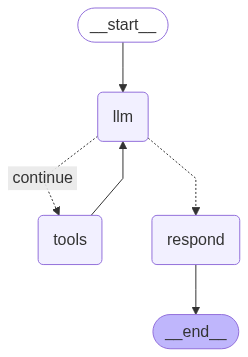

In [17]:
from IPython.display import Image, display
# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
answer = graph.invoke(input={"messages": [("human", "Tell me about the city details for Mumbai?")]})

This is 1st input from call model {'messages': [HumanMessage(content='Tell me about the city details for Mumbai?', additional_kwargs={}, response_metadata={}, id='e76fe763-bd61-452a-ba5a-962bb3b7e090')]}
This is 2nd response from call model content='' additional_kwargs={'tool_calls': [{'id': 'gwd3cgyqq', 'function': {'arguments': '{"prompt":"Mumbai city details"}', 'name': 'get_city_details'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 229, 'total_tokens': 247, 'completion_time': 0.03244393, 'prompt_time': 0.024914878, 'queue_time': 0.211347817, 'total_time': 0.057358808}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--ad14801c-18cb-4842-9ec9-0a888a9434b7-0' tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'Mumbai city details'}, 'id': 'gwd3cgyqq', 'type': 'tool_call'}] usage_metadata={'input_tokens': 

In [20]:
answer

{'messages': [HumanMessage(content='Tell me about the city details for Mumbai?', additional_kwargs={}, response_metadata={}, id='e76fe763-bd61-452a-ba5a-962bb3b7e090'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'gwd3cgyqq', 'function': {'arguments': '{"prompt":"Mumbai city details"}', 'name': 'get_city_details'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 229, 'total_tokens': 247, 'completion_time': 0.03244393, 'prompt_time': 0.024914878, 'queue_time': 0.211347817, 'total_time': 0.057358808}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ad14801c-18cb-4842-9ec9-0a888a9434b7-0', tool_calls=[{'name': 'get_city_details', 'args': {'prompt': 'Mumbai city details'}, 'id': 'gwd3cgyqq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 229, 'output_tokens': 18, 'total_tokens': 247}),
  Tool